# Analysis of low E Na events

In [1]:
from __future__ import print_function
import tables as tb
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import copy
import glob
import os

import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm
import Core.snsFunctions as sns
import Core.fitFunctions as fit
import Core.tblFunctions as tbl

import Database.loadDB as DB

matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8) # Bigger plots
%matplotlib inline
%load_ext autoreload
%autoreload 2

print("This notebook has been run last on {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

This notebook has been run last on 10/12/2016 at 09:36:35.


In [2]:
pmtdf = DB.DataPMT()
sipmdf = DB.DataSiPM()

In [3]:
adc_to_pes = -1.0/pmtdf["adc_to_pes"].values.reshape(12,1)

In [4]:
def events(print_mod=100):
    i = 0
    for filename in sorted(glob.glob("/Users/Gonzalo/github/IC/data/DATA/run_3100/*.h5")):
        with tb.open_file(filename) as h5f:
            for evt in h5f.root.RD.pmtcwf:
                yield i, evt
                if not i%print_mod:
                    print("event",i)
                i += 1

In [97]:
def sum_wf(wfs):
    return np.sum(wfs * adc_to_pes, axis=0)

def zs_wf(wf, thrs=0.5):
    wf = sum_wf(wf)
    t = np.arange(wf.size)/40.
    df = wfm.wf2df(t, wf)
    return wfm.wf_thr(df, thrs)

def find_peaks(wf, stride=100., min_length=100.):
    peaks = []
    t, e = wf.time_mus.values, wf.ene_pes.values
    begin = 0
    stride /= 25.
    min_length = int(min_length/25.)
    for i in range(1, t.size):
        if t[i] - t[i-1] > stride:
            if i - begin > min_length:
                peaks.append(wfm.wf2df(t[begin:i], e[begin:i]))
            begin = i
    if begin != i:
        peaks.append(wfm.wf2df(t[begin:i], e[begin:i]))
    return peaks

def plot_peaks(peaks):
    fig = plt.figure()
    fig.set_size_inches(9,7)
    for peak in peaks:
        fig.clear()
        plt.plot(peak.time_mus.values, peak.ene_pes.values)
        plt.show()
        
        raw_input("size: {} mus; E: {:.2} pes; time: {}->".format(len(peak)/40.,
                                                                  peak.ene_pes.sum(),
                                                                  peak.time_mus[np.argmax(peak.ene_pes.values)]))

def plot_pmap(pmap, highlight=lambda x: False):
    plt.figure().set_size_inches(9,7)
    for i, peak in enumerate(pmap):
        print("Peak #{} time {} width {} mus, charge {} pes".format(i, peak.time_mus.values[np.argmax(peak.ene_pes.values)],
                                                                    len(peak)/40., peak.ene_pes.values.sum()))
        plt.plot(peak.time_mus.values, peak.ene_pes.values, "*-" if highlight(peak) else "-")

In [ ]:
evt0 = 0
for i, evt in events():
    if i>2: break
    evt0 = evt
#plt.gcf().clear()
plt.plot(sum_wf(evt0))
plt.show()
#raw_input(">")

In [6]:
pmaps = []
for i, evt in events(1000):
    pmaps.append(find_peaks(zs_wf(evt, 1.0)))

event 0
event 1000
event 2000
event 3000
event 4000
event 5000
event 6000
event 7000
event 8000
event 9000
event 10000
event 11000
event 12000
event 13000
event 14000
event 15000
event 16000
event 17000
event 18000
event 19000
event 20000
event 21000
event 22000
event 23000
event 24000
event 25000
event 26000
event 27000
event 28000


In [53]:
t, w, e, m, n = [], [], [], [], []
for pmap in pmaps:
    n.append(len(pmap))
    for peak in pmap:
        t.append(peak.time_mus[np.argmax(peak.ene_pes.values)])
        w.append(peak.time_mus.values.size)
        e.append(peak.ene_pes.values.sum())
        m.append(peak.ene_pes.values.max())
t, w, e, m = map(np.array, [t, w, e, m])
w = w/40.
r = m/e

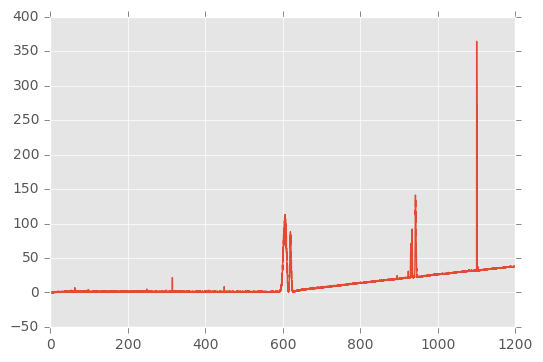

In [48]:
f = tb.open_file("/Users/Gonzalo/github/IC/data/DATA/run_3100/run_3100.gdc1next.002.next1el_3100.root.h5")
plt.plot(np.arange(48000)/40., sum_wf(f.root.RD.pmtcwf[10]))
f.close()

In [32]:
skip = 0
maxn = 10
nn = 0
for i, pmap in enumerate(pmaps):
    if 4500 < max(peak.ene_pes.values.sum() for peak in pmap) < 7000:
        nn += 1
        if n > skip:
            print(i)
    if nn>= maxn + skip:
        break

92
101
168
174
181
208
307
313
370
375


Peak #0 time 539.5 width 0.175 mus, charge 22.7326088701 pes
Peak #1 time 601.3 width 7.05 mus, charge 6780.00551544 pes


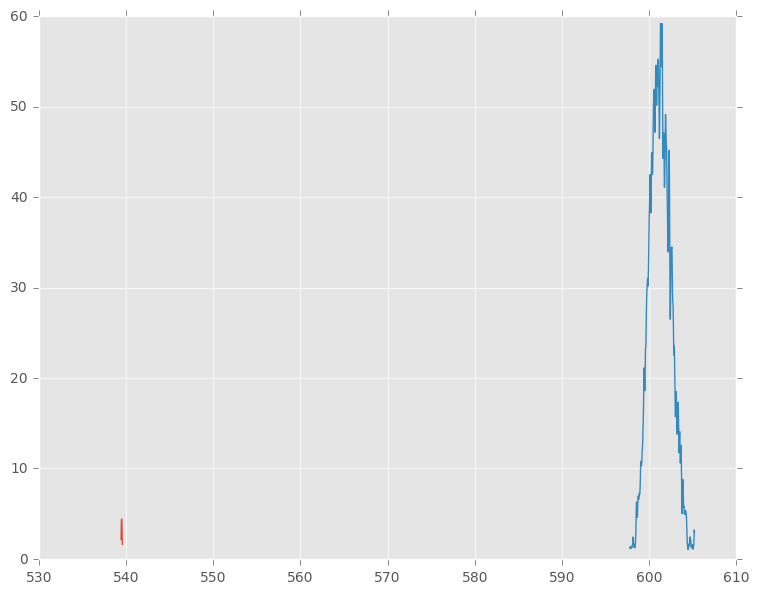

In [111]:
plot_pmap(pmaps[101])
#plt.xlim(590,610)
#plt.ylim(0,2)

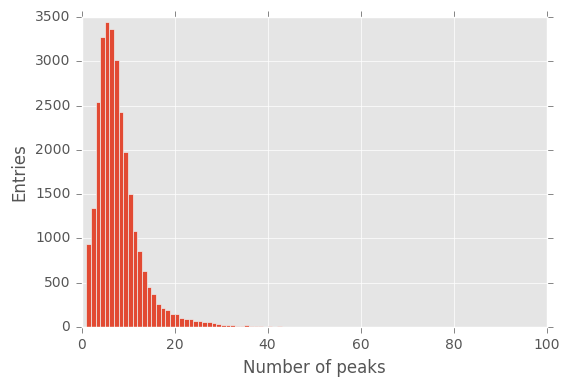

In [54]:
h = plt.hist(n, 100, range=(0,100))
plt.xlabel("Number of peaks")
plt.ylabel("Entries")

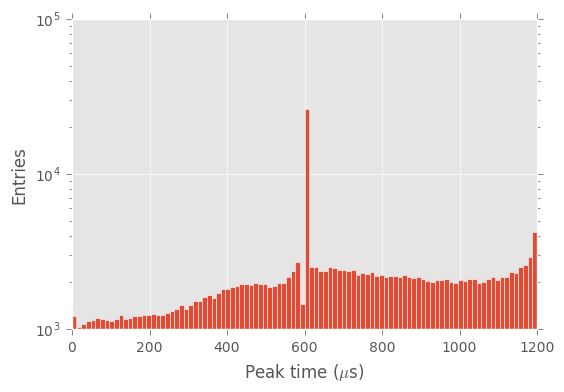

In [55]:
h = plt.hist(t, 100, range=(0,1200))
plt.yscale("log")
plt.xlabel("Peak time ($\mu$s)")
plt.ylabel("Entries")

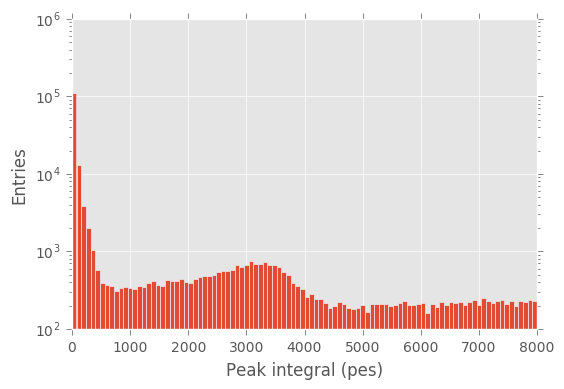

In [56]:
h = plt.hist(e, 100, range=(0,8000))
plt.yscale("log")
plt.xlabel("Peak integral (pes)")
plt.ylabel("Entries")

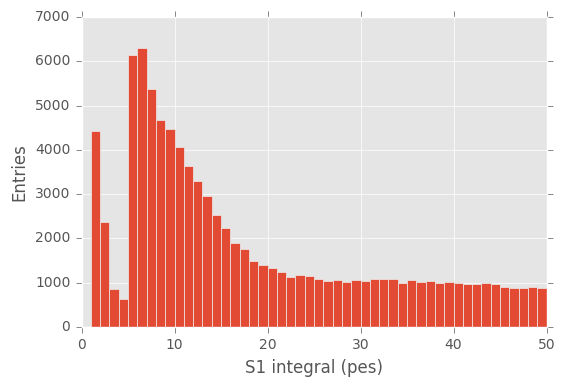

In [122]:
h = plt.hist(e, 50, range=(0,50))
plt.xlabel("S1 integral (pes)")
plt.ylabel("Entries")

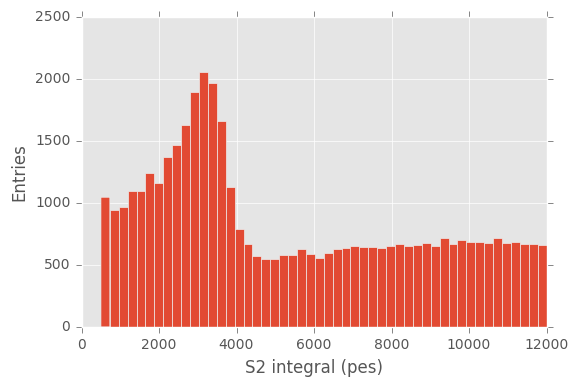

In [59]:
h = plt.hist(e, 50, range=(500, 12000))
plt.xlabel("S2 integral (pes)")
plt.ylabel("Entries")

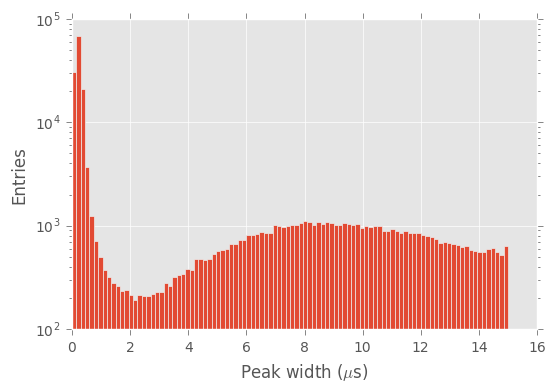

In [60]:
h = plt.hist(w, 100, range=(0, 15))
plt.yscale("log")
plt.xlabel("Peak width ($\mu$s)")
plt.ylabel("Entries")

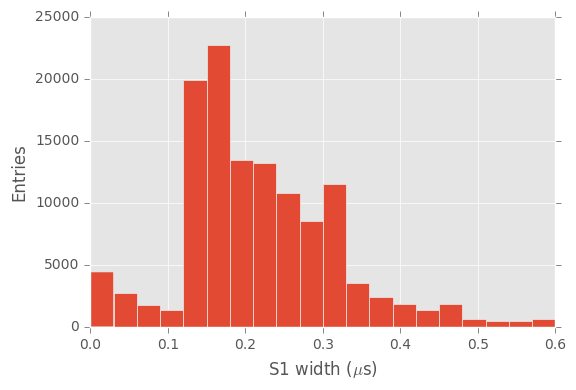

In [72]:
h = plt.hist(w, 20, range=(0, .6))
plt.xlabel("S1 width ($\mu$s)")
plt.ylabel("Entries")

In [74]:
wselection = (w>0.12) & (w<0.4)

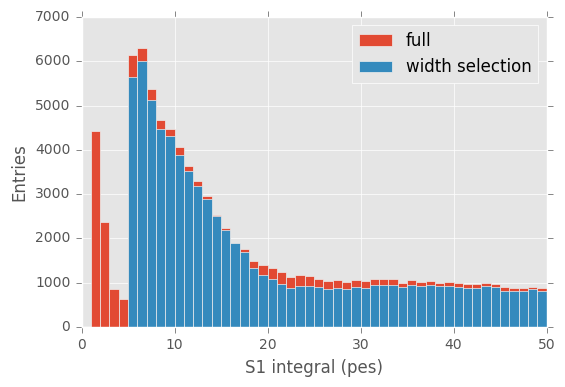

In [123]:
h = plt.hist(e, 50, range=(0,50), label="full")
h = plt.hist(e[wselection], 50, range=(0,50), label="width selection")
plt.xlabel("S1 integral (pes)")
plt.ylabel("Entries")
plt.legend()

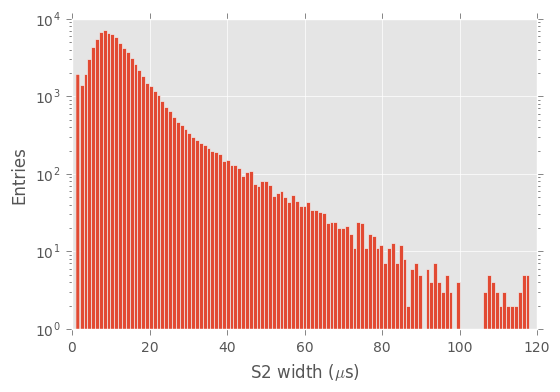

In [65]:
h = plt.hist(w, 120, range=(1, 120.))
plt.yscale("log")
plt.xlabel("S2 width ($\mu$s)")
plt.ylabel("Entries")

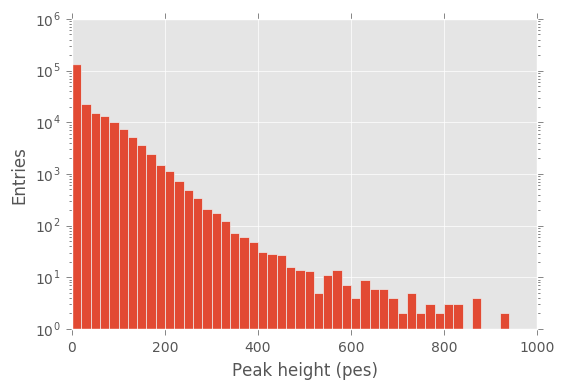

In [66]:
h = plt.hist(m, 50, range=(0, 1000.))
plt.yscale("log")
plt.xlabel("Peak height (pes)")
plt.ylabel("Entries")

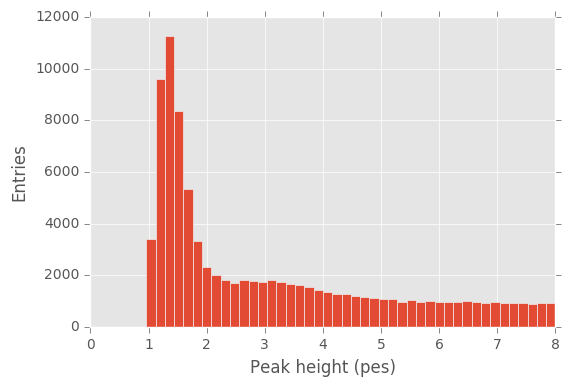

In [118]:
h = plt.hist(m, 50, range=(0, 8.))
plt.xlabel("Peak height (pes)")
plt.ylabel("Entries")

In [115]:
hselection = m>2.

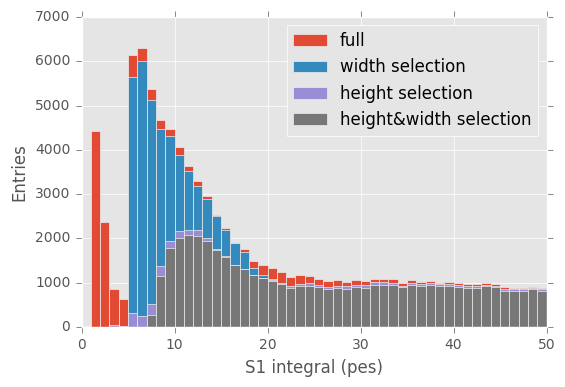

In [124]:
h = plt.hist(e, 50, range=(0,50), label="full")
h = plt.hist(e[wselection], 50, range=(0,50), label="width selection")
h = plt.hist(e[hselection], 50, range=(0,50), label="height selection")
h = plt.hist(e[wselection & hselection], 50, range=(0,50), label="height&width selection")
plt.xlabel("S1 integral (pes)")
plt.ylabel("Entries")
plt.legend()

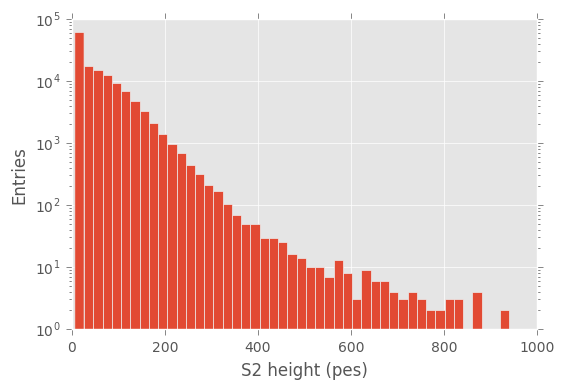

In [125]:
h = plt.hist(m, 50, range=(6, 1000.))
plt.yscale("log")
plt.xlabel("S2 height (pes)")
plt.ylabel("Entries")

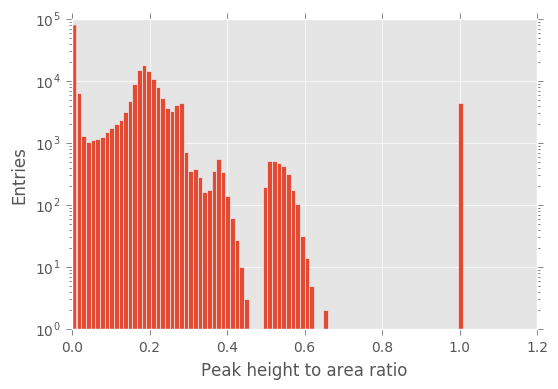

In [126]:
h = plt.hist(r, 100, range=(0, 1.2))
plt.yscale("log")
plt.xlabel("Peak height to area ratio")
plt.ylabel("Entries")

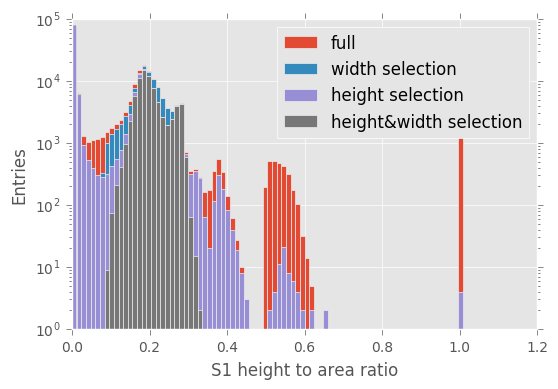

In [127]:
h = plt.hist(r, 100, range=(0.,1.2), label="full")
h = plt.hist(r[wselection], 100, range=(0.,1.2), label="width selection")
h = plt.hist(r[hselection], 100, range=(0.,1.2), label="height selection")
h = plt.hist(r[wselection & hselection], 100, range=(0.,1.2), label="height&width selection")
plt.xlabel("S1 height to area ratio")
plt.ylabel("Entries")
plt.yscale("log")
plt.legend()

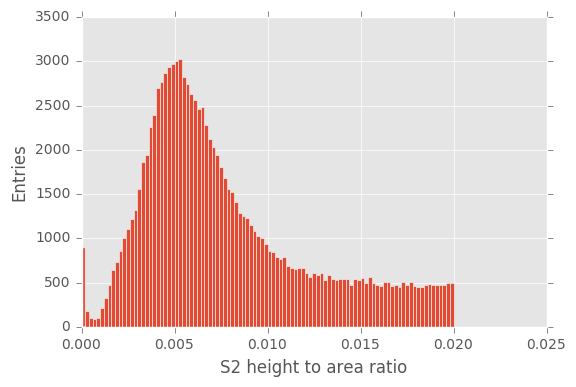

In [58]:
h = plt.hist(r, 100, range=(0., 0.02))
plt.xlabel("S2 height to area ratio")
plt.ylabel("Entries")

In [141]:
trueS1 = lambda peak: peak.time_mus.max() < 600. and 0.12 < len(peak)/40. < 0.4 and peak.ene_pes.values.max() < 2. and 0.06 < peak.ene_pes.values.max() / peak.ene_pes.values.sum() < 0.3 

Peak #0 time 493.7 width 0.125 mus, charge 15.8143247964 pes
Peak #1 time 601.125 width 7.125 mus, charge 6140.2413777 pes
Peak #2 time 692.25 width 8.175 mus, charge 3314.97856009 pes


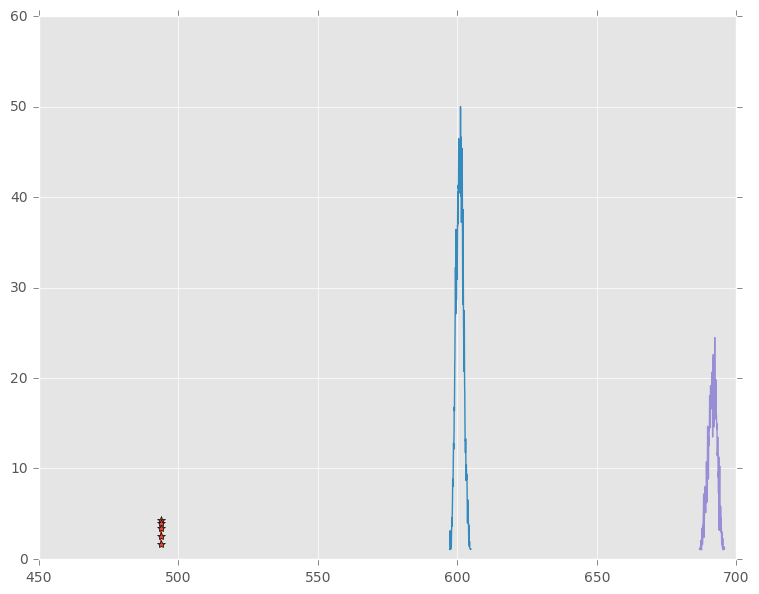


Peak #0 time 539.5 width 0.175 mus, charge 22.7326088701 pes
Peak #1 time 601.3 width 7.05 mus, charge 6780.00551544 pes


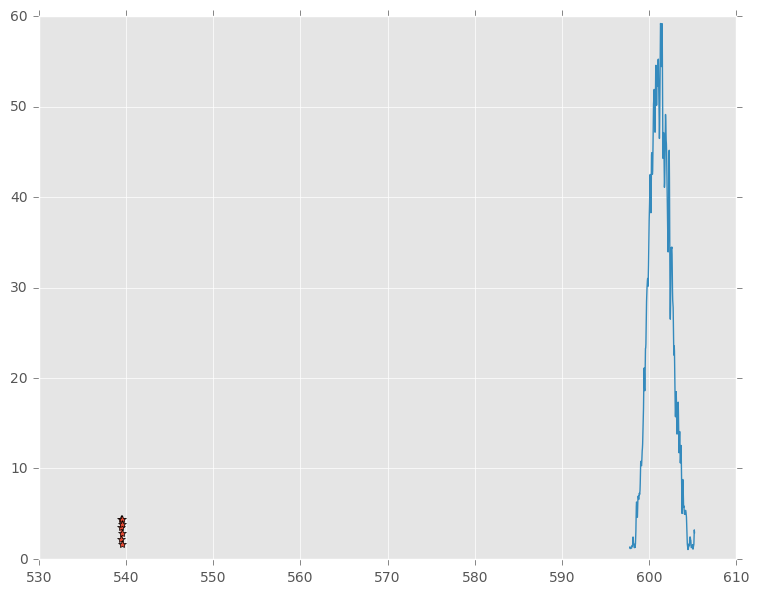


Peak #0 time 600.225 width 1.45 mus, charge 6030.27488125 pes


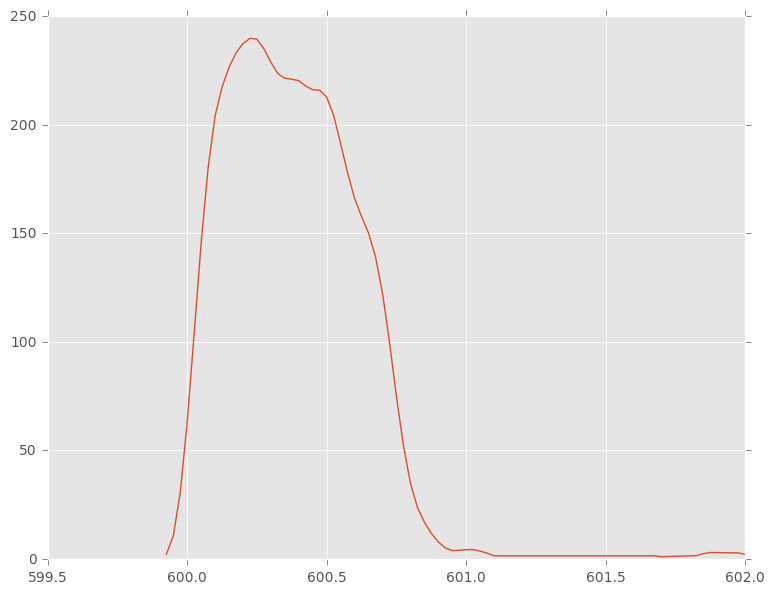


Peak #0 time 600.975 width 2.825 mus, charge 5772.59967513 pes
Peak #1 time 822.95 width 0.125 mus, charge 5.53363874609 pes


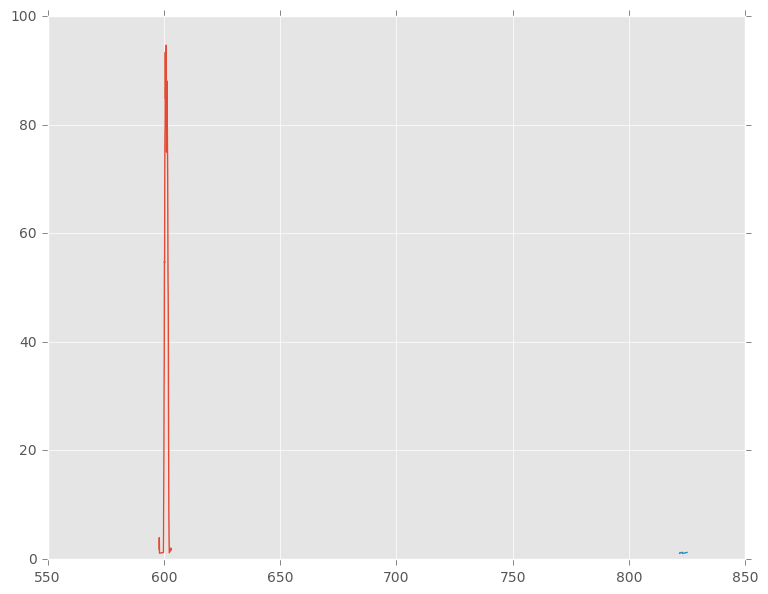


Peak #0 time 512.6 width 0.2 mus, charge 32.4555880577 pes
Peak #1 time 601.025 width 7.05 mus, charge 6278.04034254 pes


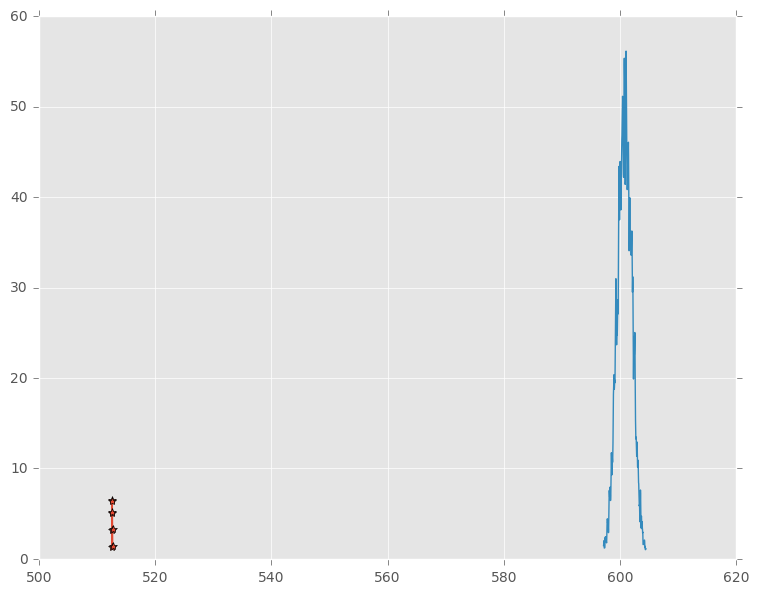


Peak #0 time 601.125 width 4.85 mus, charge 5716.28602625 pes


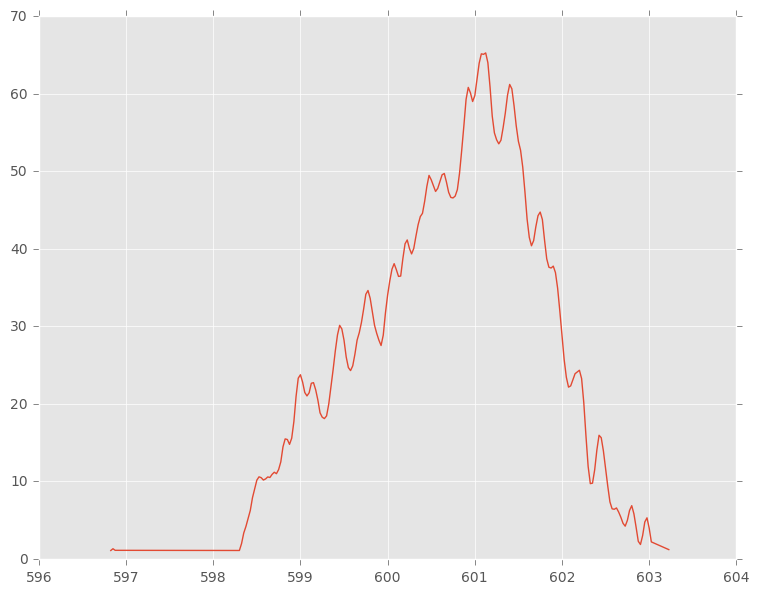


Peak #0 time 565.95 width 0.125 mus, charge 9.48523905405 pes
Peak #1 time 601.25 width 5.15 mus, charge 5180.02781557 pes
Peak #2 time 649.2 width 0.375 mus, charge 159.97068312 pes
Peak #3 time 656.125 width 0.025 mus, charge 1.15866991515 pes


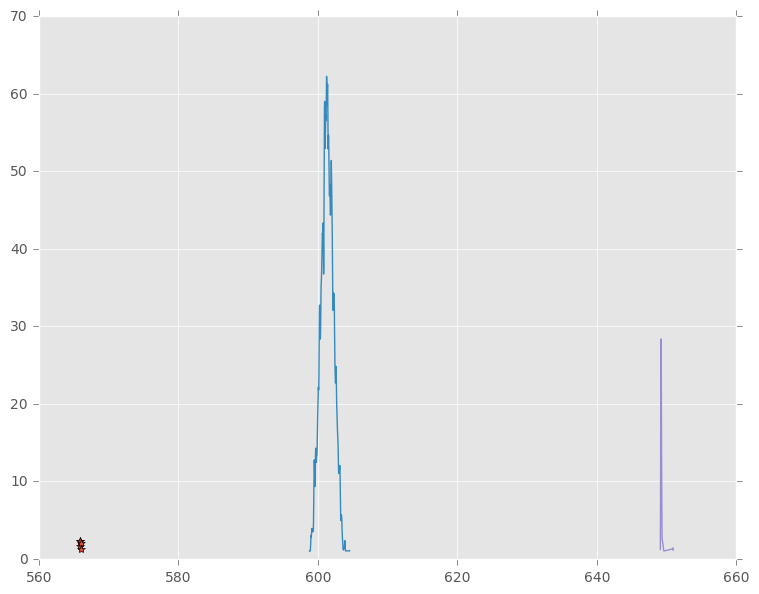


Peak #0 time 7.175 width 5.125 mus, charge 1875.24529481 pes
Peak #1 time 97.825 width 6.1 mus, charge 2013.85869126 pes
Peak #2 time 189.575 width 3.125 mus, charge 1628.36167625 pes
Peak #3 time 602.5 width 8.05 mus, charge 6809.03025888 pes
Peak #4 time 927.275 width 7.35 mus, charge 6410.74099647 pes


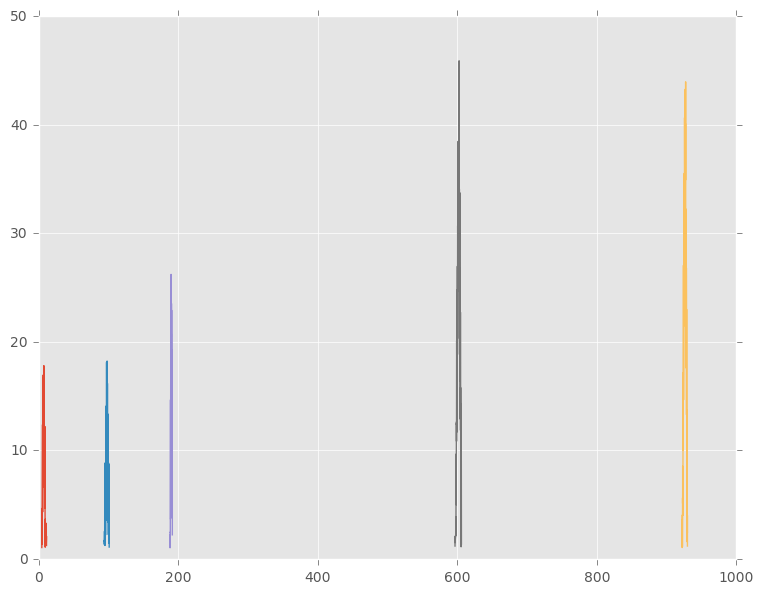


Peak #0 time 601.625 width 4.7 mus, charge 6758.34469285 pes
Peak #1 time 624.775 width 5.175 mus, charge 5057.43168749 pes


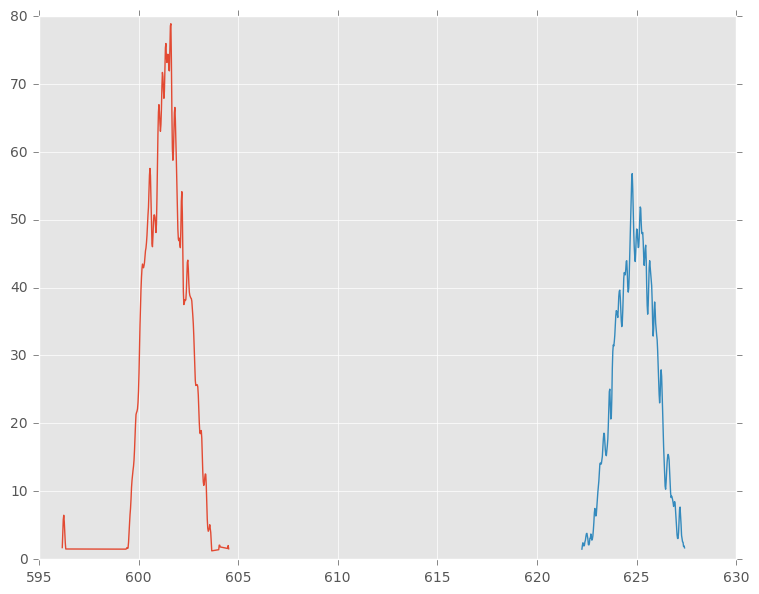


Peak #0 time 399.7 width 0.125 mus, charge 14.0323703331 pes
Peak #1 time 600.675 width 6.0 mus, charge 6409.08344639 pes
Peak #2 time 969.8 width 0.125 mus, charge 12.875142135 pes
Peak #3 time 1063.75 width 0.075 mus, charge 6.48579696236 pes


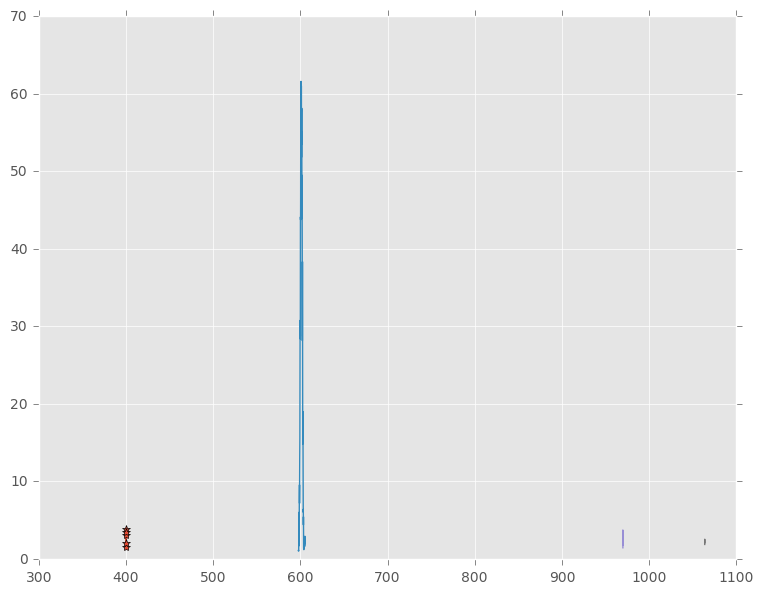


Peak #0 time 415.6 width 0.2 mus, charge 29.7419634753 pes
Peak #1 time 500.65 width 0.2 mus, charge 23.5457867469 pes
Peak #2 time 600.425 width 7.55 mus, charge 6752.71856557 pes
Peak #3 time 665.675 width 0.15 mus, charge 6.8448918675 pes
Peak #4 time 1094.35 width 0.025 mus, charge 1.0292489615 pes


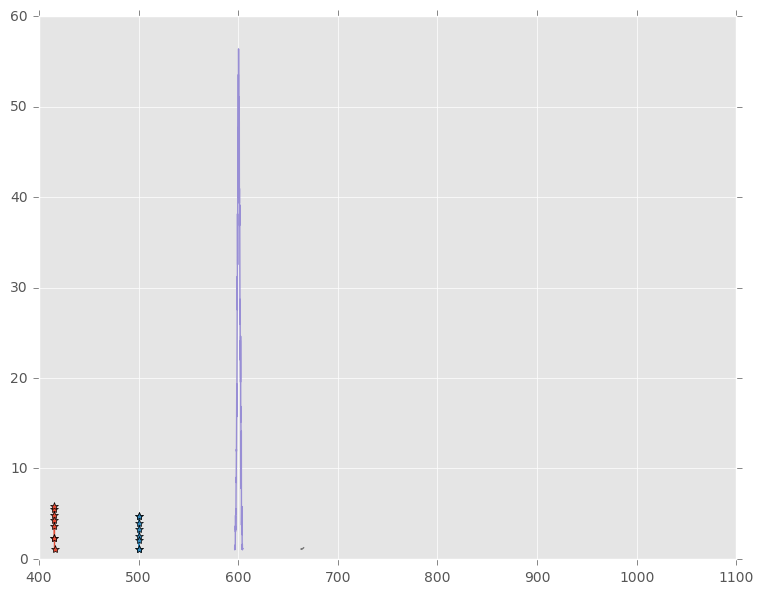


Peak #0 time 246.95 width 10.65 mus, charge 4295.66219868 pes
Peak #1 time 510.875 width 0.2 mus, charge 25.6323336973 pes
Peak #2 time 600.975 width 7.875 mus, charge 6630.9017486 pes
Peak #3 time 1061.7 width 0.35 mus, charge 90.255377198 pes


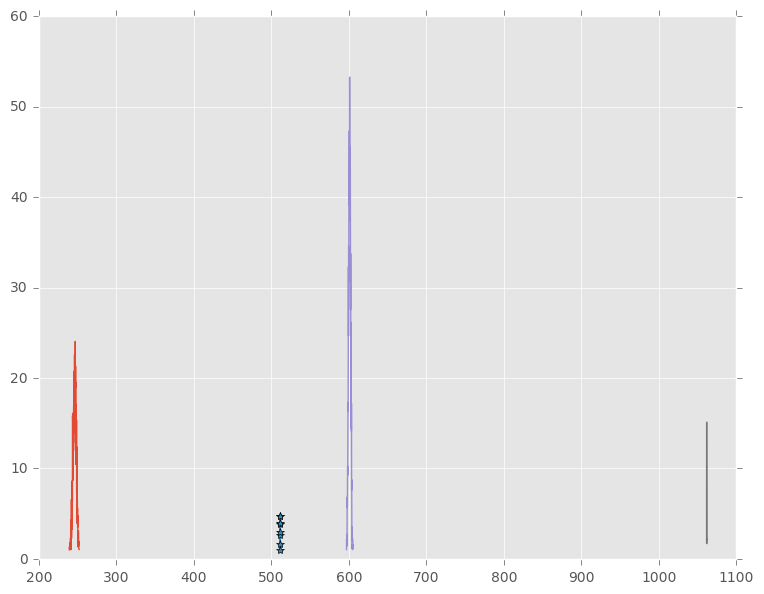


Peak #0 time 7.825 width 0.125 mus, charge 14.5360654126 pes
Peak #1 time 349.075 width 9.325 mus, charge 3144.04317134 pes
Peak #2 time 469.3 width 10.575 mus, charge 1738.55614763 pes
Peak #3 time 600.425 width 1.825 mus, charge 5184.81292643 pes
Peak #4 time 870.925 width 0.075 mus, charge 6.65901985045 pes


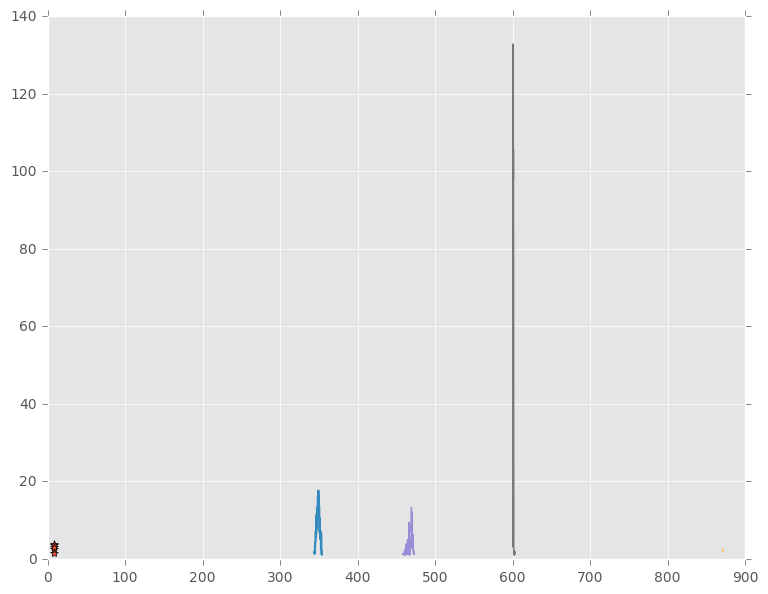


Peak #0 time 17.875 width 0.125 mus, charge 10.3775045386 pes
Peak #1 time 600.5 width 3.55 mus, charge 5844.9318655 pes
Peak #2 time 1069.0 width 0.225 mus, charge 53.239053216 pes
Peak #3 time 1130.15 width 0.225 mus, charge 63.4328271199 pes
Peak #4 time 1199.775 width 0.75 mus, charge 68.0556319426 pes


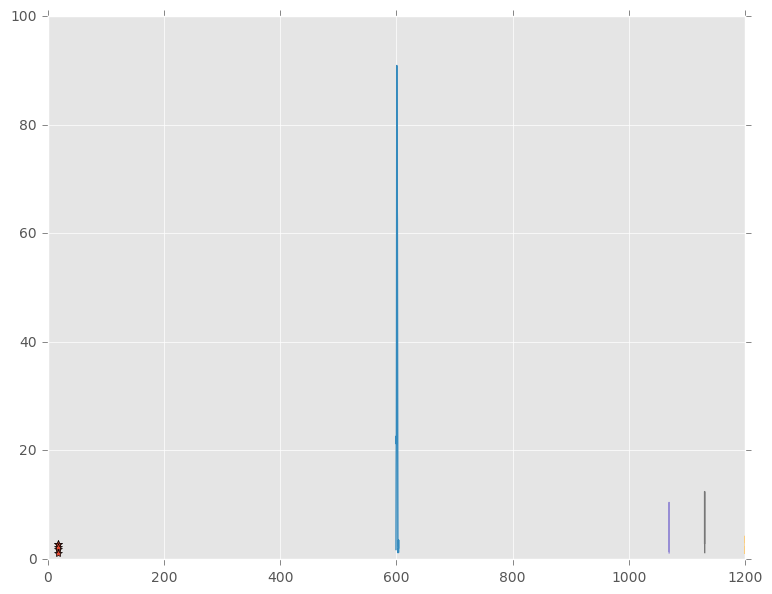


Peak #0 time 67.05 width 6.625 mus, charge 5824.75544089 pes
Peak #1 time 477.65 width 0.15 mus, charge 17.8268796404 pes
Peak #2 time 600.325 width 7.725 mus, charge 5349.93830217 pes


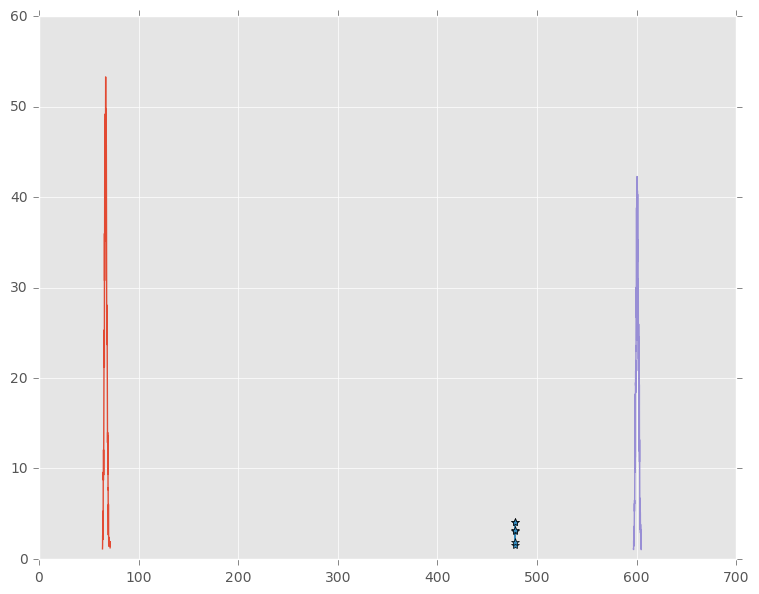


Peak #0 time 3.075 width 7.3 mus, charge 3048.96465166 pes
Peak #1 time 601.6 width 4.375 mus, charge 5745.87887287 pes
Peak #2 time 1186.725 width 0.075 mus, charge 11.1837469208 pes


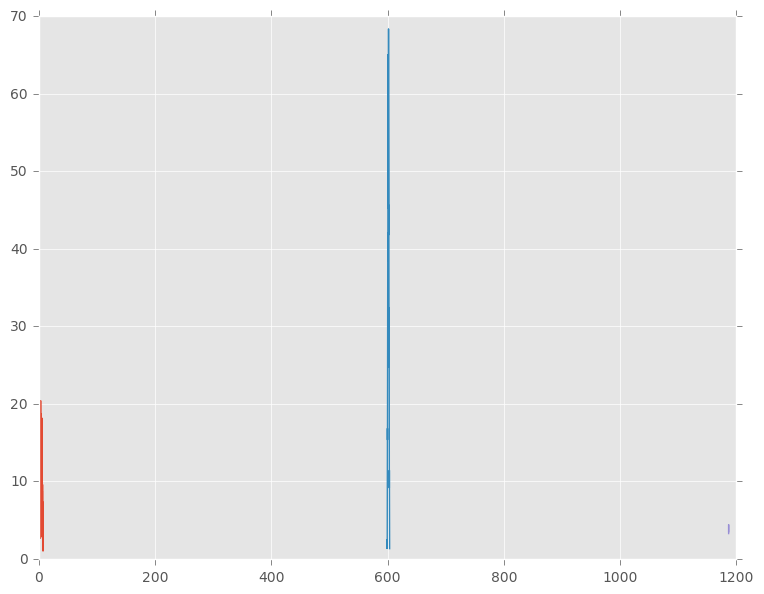


Peak #0 time 569.875 width 0.2 mus, charge 24.0571566872 pes
Peak #1 time 600.95 width 5.35 mus, charge 6631.05136942 pes
Peak #2 time 1179.625 width 0.15 mus, charge 19.4864170058 pes


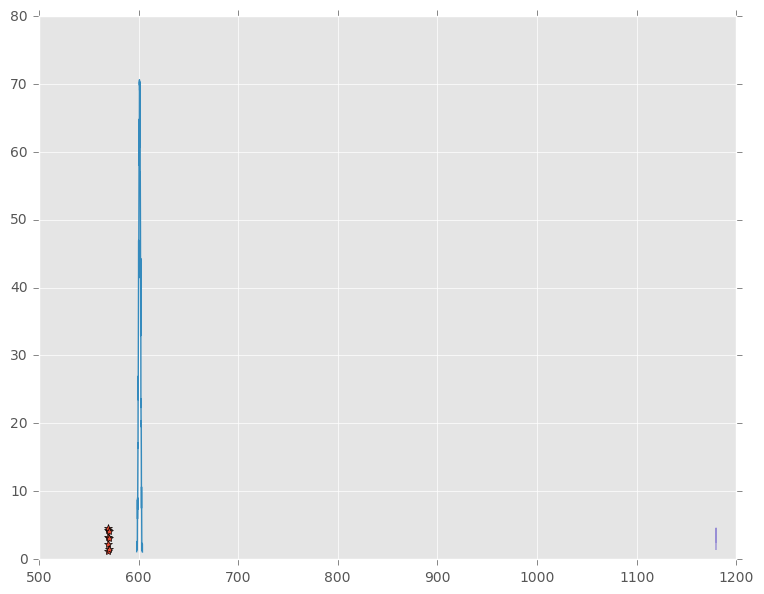


Peak #0 time 519.375 width 0.35 mus, charge 25.6478643302 pes
Peak #1 time 601.15 width 6.5 mus, charge 6432.83376942 pes
Peak #2 time 716.1 width 0.125 mus, charge 12.1707622693 pes
Peak #3 time 933.5 width 5.475 mus, charge 583.987076284 pes
Peak #4 time 1170.7 width 0.2 mus, charge 24.5206887766 pes


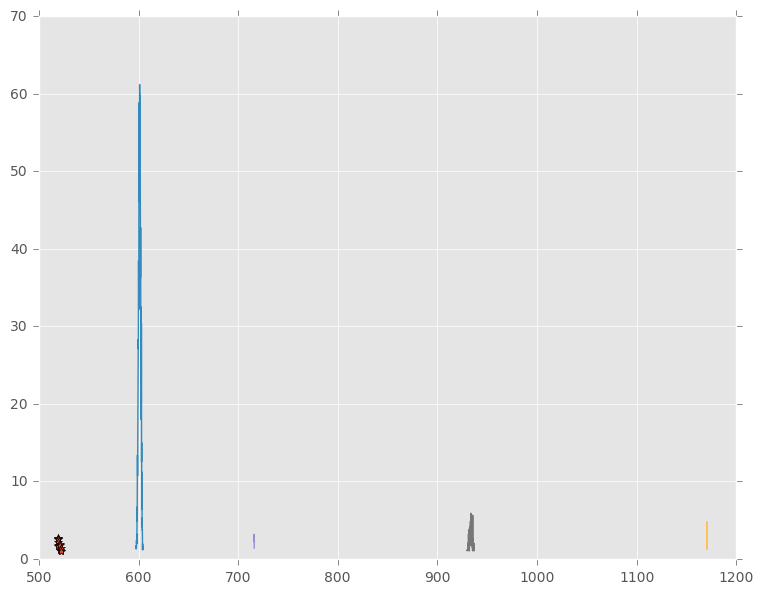


Peak #0 time 36.075 width 0.2 mus, charge 14.6386524485 pes
Peak #1 time 564.875 width 0.175 mus, charge 8.79325853218 pes
Peak #2 time 601.375 width 5.15 mus, charge 6114.94266411 pes
Peak #3 time 992.925 width 0.4 mus, charge 70.1789493164 pes
Peak #4 time 1046.45 width 0.225 mus, charge 55.5252950138 pes


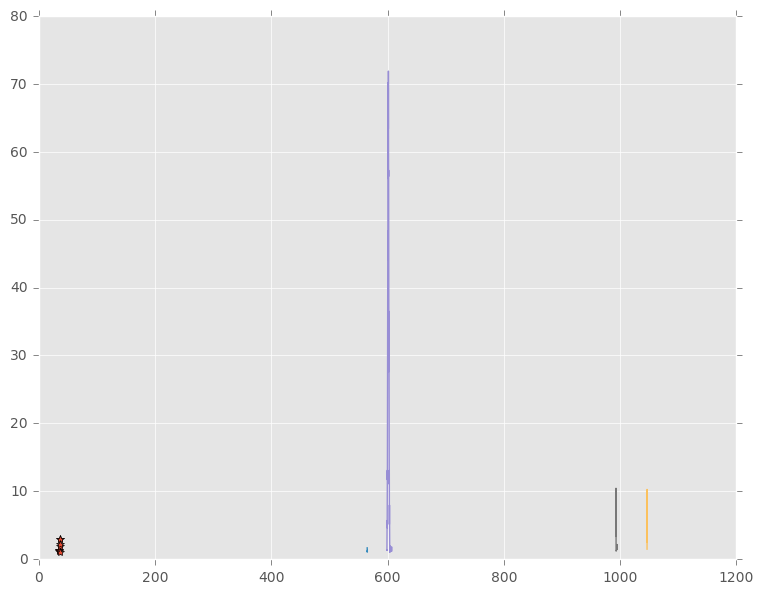


Peak #0 time 475.975 width 0.2 mus, charge 38.7494508083 pes
Peak #1 time 568.4 width 7.575 mus, charge 5125.33795965 pes
Peak #2 time 600.45 width 8.225 mus, charge 6511.48473012 pes
Peak #3 time 851.375 width 0.05 mus, charge 3.13115543436 pes


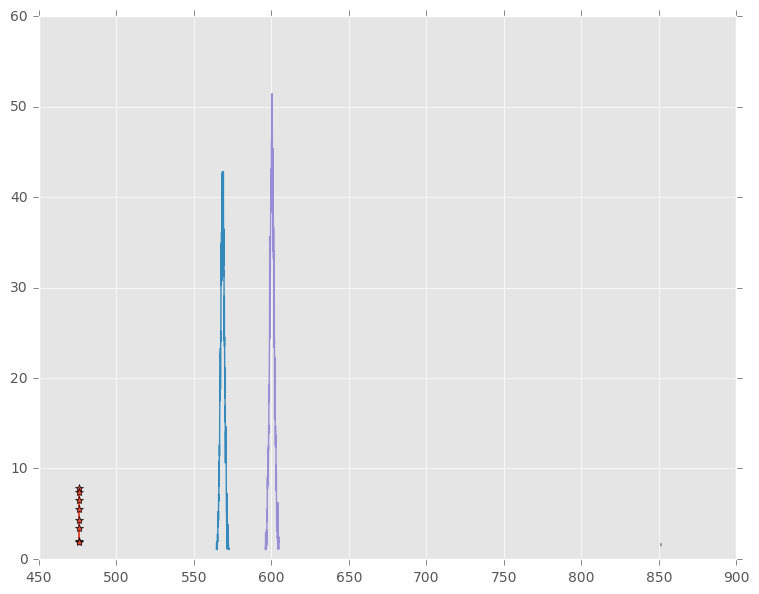


Peak #0 time 455.875 width 0.15 mus, charge 14.3819457024 pes
Peak #1 time 600.65 width 8.7 mus, charge 6116.24948684 pes
Peak #2 time 919.125 width 0.225 mus, charge 24.5175454134 pes
Peak #3 time 1126.65 width 13.325 mus, charge 5727.46109815 pes


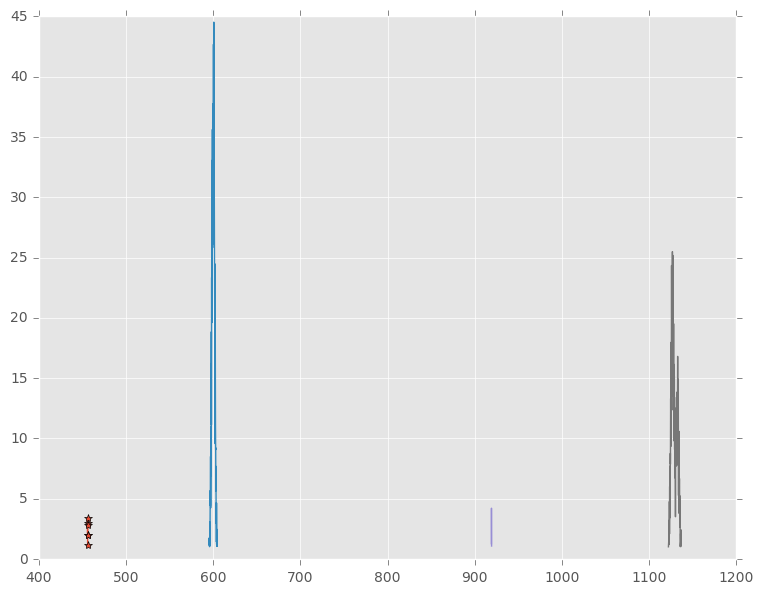


Peak #0 time 546.775 width 0.25 mus, charge 80.2856465933 pes
Peak #1 time 601.2 width 6.85 mus, charge 6203.31337278 pes
Peak #2 time 623.95 width 9.95 mus, charge 2826.8618232 pes
Peak #3 time 841.325 width 0.15 mus, charge 15.7397126132 pes


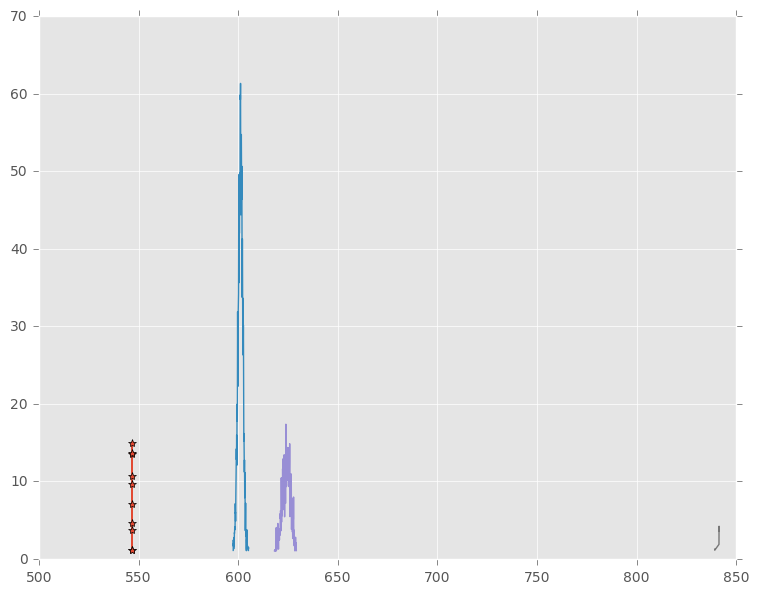


Peak #0 time 553.825 width 0.175 mus, charge 15.6577052651 pes
Peak #1 time 587.775 width 4.3 mus, charge 2128.25489265 pes
Peak #2 time 600.6 width 5.675 mus, charge 5552.12423489 pes
Peak #3 time 657.65 width 7.375 mus, charge 3558.62324857 pes
Peak #4 time 1003.525 width 0.3 mus, charge 142.495885965 pes
Peak #5 time 1148.1 width 0.225 mus, charge 57.7635154511 pes


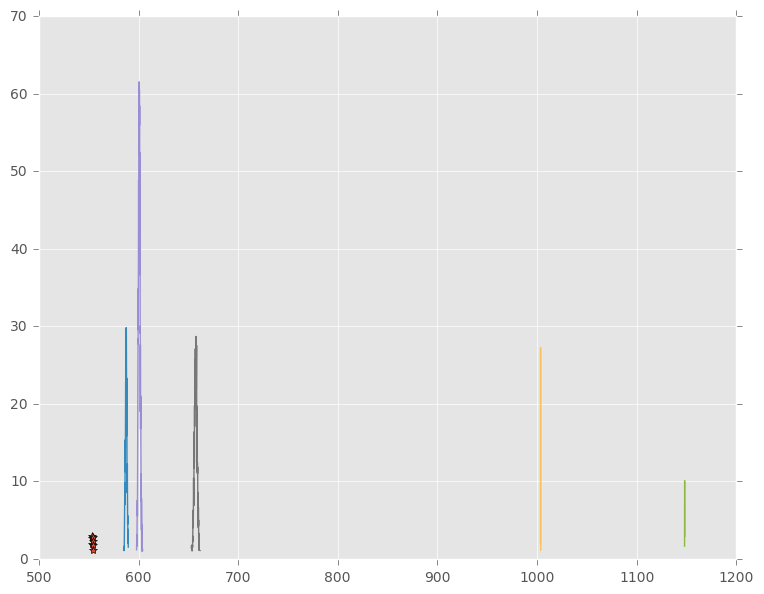


Peak #0 time 289.725 width 0.125 mus, charge 9.52677073074 pes
Peak #1 time 478.975 width 0.2 mus, charge 29.8739515782 pes
Peak #2 time 601.1 width 7.875 mus, charge 5272.77307833 pes
Peak #3 time 693.075 width 0.125 mus, charge 14.5038551554 pes


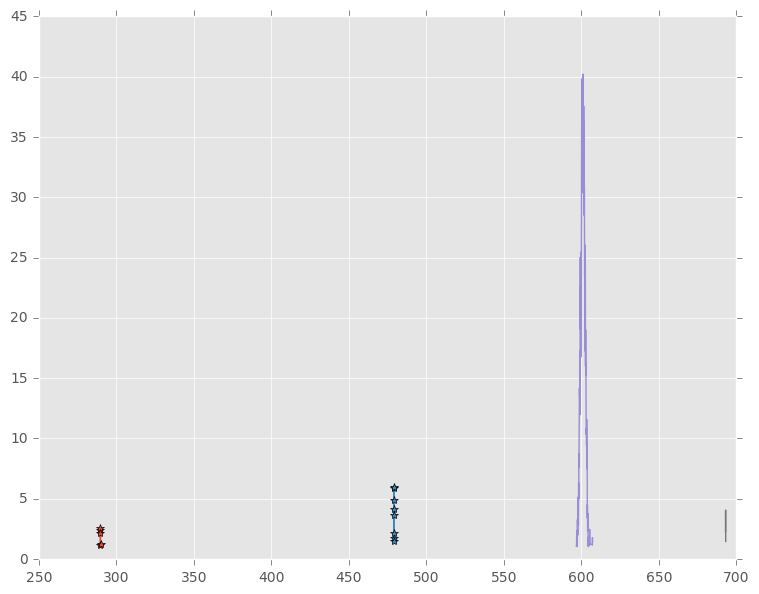


Peak #0 time 253.7 width 0.9 mus, charge 1639.93658433 pes
Peak #1 time 452.85 width 0.225 mus, charge 33.4595769189 pes
Peak #2 time 600.775 width 9.1 mus, charge 6170.20514401 pes


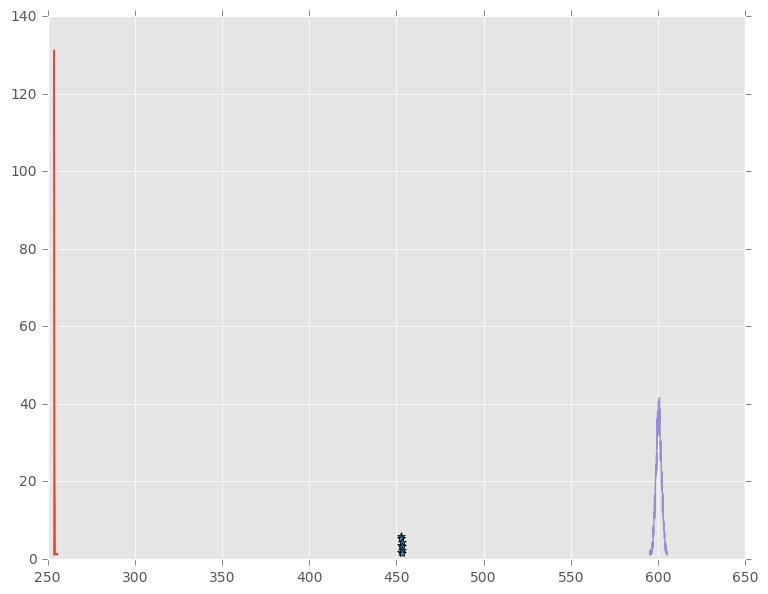


Peak #0 time 561.3 width 0.225 mus, charge 25.8407582214 pes
Peak #1 time 601.325 width 5.375 mus, charge 6539.43019009 pes
Peak #2 time 701.725 width 7.3 mus, charge 3115.2736678 pes
Peak #3 time 1126.95 width 0.225 mus, charge 63.4338979731 pes


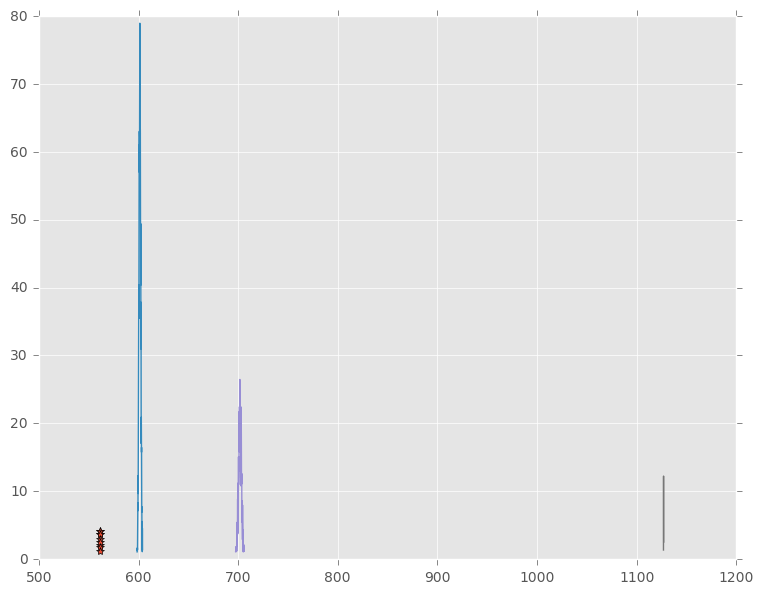

KeyboardInterrupt: 

In [138]:
for pmap in pmaps:
#    if len(filter(trueS1, pmap)) < 1 or not (4500 < max(peak.ene_pes.values.sum() for peak in pmap) < 7000):
#        for peak in pmap:
#            print(len(peak)/40., peak.ene_pes.values.max(), peak.ene_pes.values.max() / peak.ene_pes.values.sum())
#        raw_input()
#        continue
    if not (4500 < max(peak.ene_pes.values.sum() for peak in pmap) < 7000): continue
    plt.gcf().clear()
    plot_pmap(pmap, trueS1)
    plt.show()
    raw_input()

In [144]:
trueS1 = lambda peak: peak.time_mus.max() < 600. and 0.12 < len(peak)/40. < 0.4 and peak.ene_pes.values.max() < 2. and 0.06 < peak.ene_pes.values.max() / peak.ene_pes.values.sum() < 0.3 
trueS2 = lambda peak: 4500 < peak.ene_pes.values.sum() < 7000 and abs(peak.time_mus.values[np.argmax(peak.ene_pes.values)] - 600) < 5

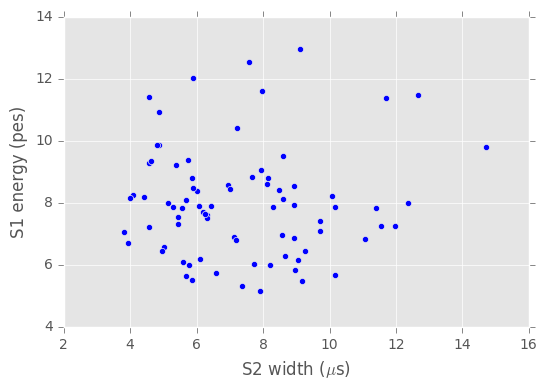

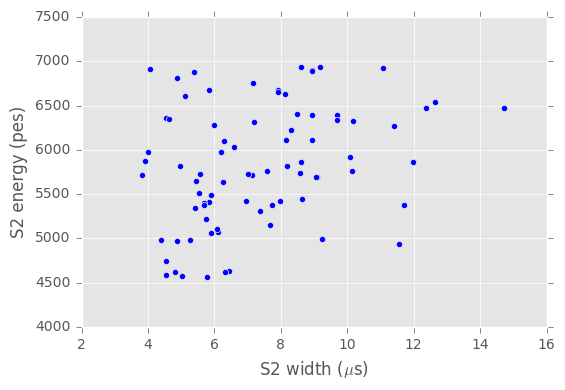

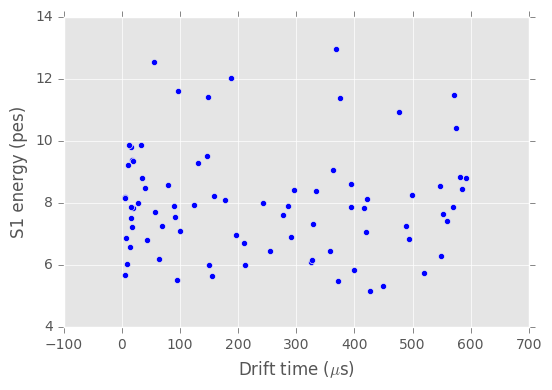

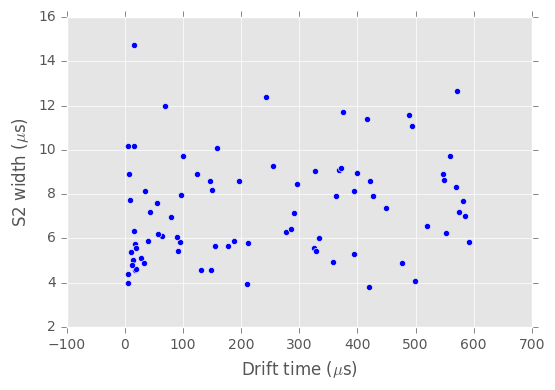

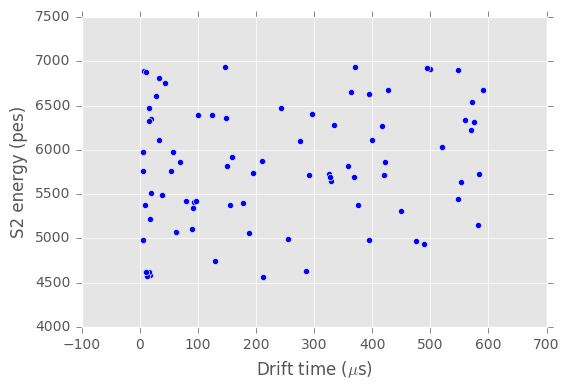

In [145]:
ww = []
ss = []
ee = []
zz = []
for pmap in pmaps:
    s1 = filter(trueS1, pmap)
    s2 = filter(trueS2, pmap)
    if len(s1) == len(s2) == 1:
        s1, s2= s1[0], s2[0]
        
        ww.append(s2.time_mus.values[-1] - s2.time_mus.values[0])
        ss.append(s1.ene_pes.values.sum())
        ee.append(s2.ene_pes.values.sum())
        zz.append(s2.time_mus.values[0] - s1.time_mus[0])
plt.scatter(ww, ss)
plt.xlabel("S2 width ($\mu$s)")
plt.ylabel("S1 energy (pes)")
#plt.ylim(0,20)

plt.figure()
plt.scatter(ww, ee)
plt.xlabel("S2 width ($\mu$s)")
plt.ylabel("S2 energy (pes)")

plt.figure()
plt.scatter(zz, ss)
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("S1 energy (pes)")

plt.figure()
plt.scatter(zz, ww)
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("S2 width ($\mu$s)")

plt.figure()
plt.scatter(zz, ee)
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("S2 energy (pes)")

In [149]:
trueS1 = lambda peak: peak.time_mus.max() < 600. and 0.12 < len(peak)/40. < 0.4 and peak.ene_pes.values.max() > 2. and 0.06 < peak.ene_pes.values.max() / peak.ene_pes.values.sum() < 0.3 
trueS2 = lambda peak: 4500 < peak.ene_pes.values.sum() < 7000 and abs(peak.time_mus.values[np.argmax(peak.ene_pes.values)] - 600) < 5

In [157]:
ww = []
ss = []
ee = []
zz = []
for pmap in pmaps:
    s1 = filter(trueS1, pmap)
    s2 = filter(trueS2, pmap)
    if len(s1) == len(s2) == 1:
        s1, s2= s1[0], s2[0]
        
        ww.append(s2.time_mus.values[-1] - s2.time_mus.values[0])
        ss.append(s1.ene_pes.values.sum())
        ee.append(s2.ene_pes.values.sum())
        zz.append(s2.time_mus.values[0] - s1.time_mus[0])

ww = np.array(ww)
ss = np.array(ss)
ee = np.array(ee)
zz = np.array(zz)

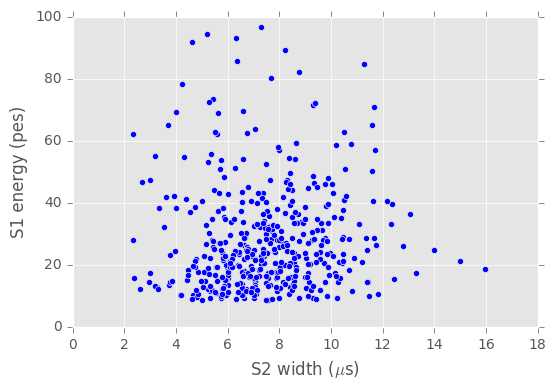

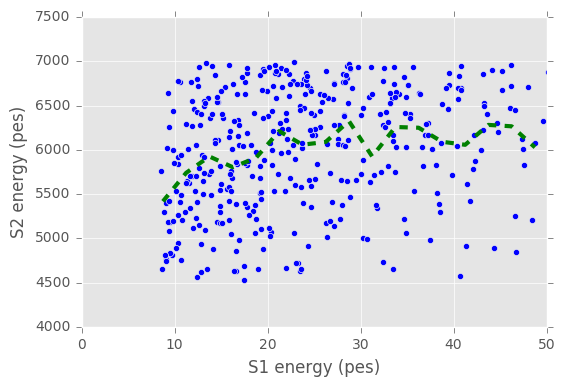

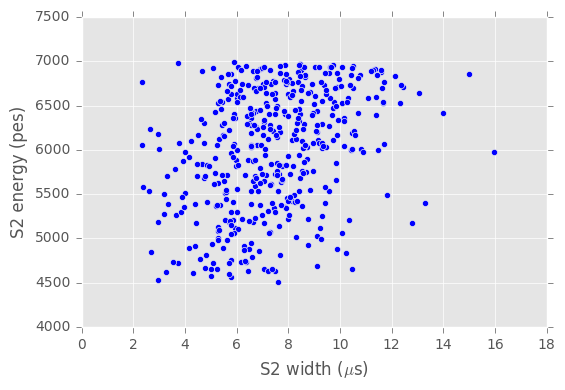

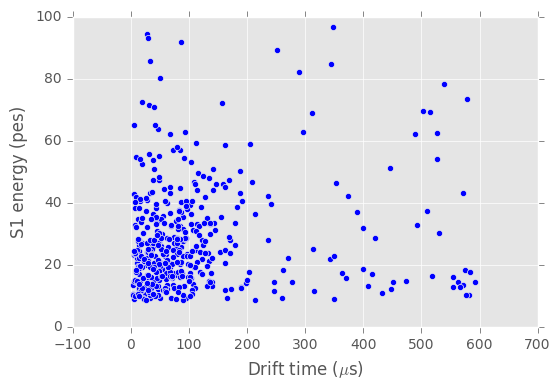

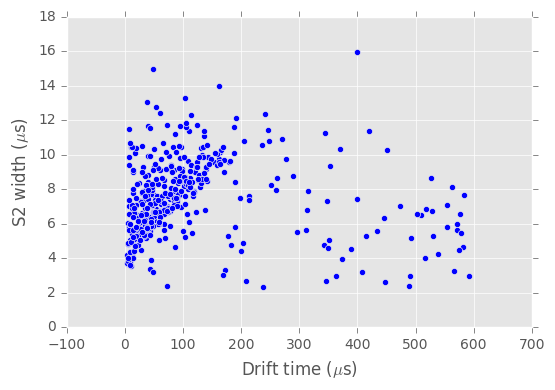

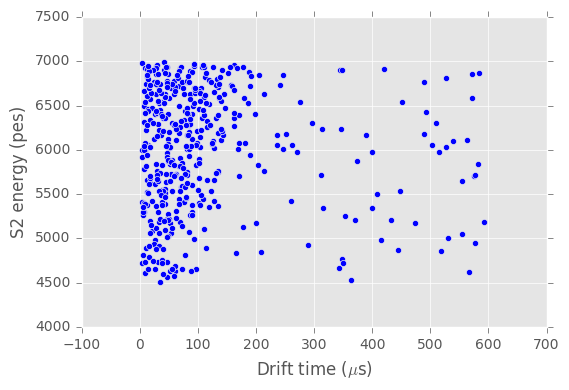

In [159]:
plt.scatter(ww, ss)
plt.xlabel("S2 width ($\mu$s)")
plt.ylabel("S1 energy (pes)")
plt.ylim(0,100)

plt.figure()
plt.scatter(ss, ee)
sp, ep, er = fit.profileX(ss, ee, 20, (0, 50))
plt.plot(sp, ep, "g--", linewidth=3)
plt.xlabel("S1 energy (pes)")
plt.ylabel("S2 energy (pes)")
plt.xlim(0,50)

plt.figure()
plt.scatter(ww, ee)
plt.xlabel("S2 width ($\mu$s)")
plt.ylabel("S2 energy (pes)")

plt.figure()
plt.scatter(zz, ss)
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("S1 energy (pes)")
plt.ylim(0,100)

plt.figure()
plt.scatter(zz, ww)
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("S2 width ($\mu$s)")

plt.figure()
plt.scatter(zz, ee)
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("S2 energy (pes)")

In [100]:
pmap

[    ene_pes  time_mus
 0  2.631814    24.875
 1  4.749274    24.900
 2  6.131607    24.925
 3  6.580212    24.950
 4  5.873091    24.975
 5  4.834909    25.000
 6  3.943609    25.025
 7  3.114383    25.050
 8  2.131705    25.075
 9  1.494959    25.100,       ene_pes  time_mus
 0    1.059479   224.475
 1    1.236070   224.700
 2    1.361975   224.725
 3    1.684273   224.750
 4    1.724465   224.775
 5    1.304213   224.800
 6    1.122423   225.075
 7    1.251036   225.100
 8    1.147141   225.125
 9    1.102268   225.250
 10   1.520743   225.275
 11   1.791586   225.300
 12   2.049743   225.325
 13   2.214363   225.350
 14   2.330012   225.375
 15   2.171306   225.400
 16   1.834904   225.425
 17   1.389675   225.450
 18   1.223154   225.475
 19   1.250420   225.500
 20   1.509605   225.525
 21   1.914733   225.550
 22   2.590340   225.575
 23   3.317472   225.600
 24   3.742770   225.625
 25   4.098026   225.650
 26   4.295268   225.675
 27   3.818933   225.700
 28   3.263899   225.7

In [160]:
trueS1 = lambda peak: 0.16 < len(peak)/40. < 0.4
trueS2 = lambda peak: 1.0 < len(peak)/40. < 200

In [162]:
maxs1, maxs2 = [], []
for pmap in pmaps:
    s1s = filter(trueS1, pmap)
    s2s = filter(trueS2, pmap)
    if not s1s or not s2s:
        continue
    maxs1.append(max(peak.ene_pes.values.sum() for peak in s1s))
    maxs2.append(max(peak.ene_pes.values.sum() for peak in s2s))

maxs1 = np.array(maxs1)
maxs2 = np.array(maxs2)

(0, 200000.0)

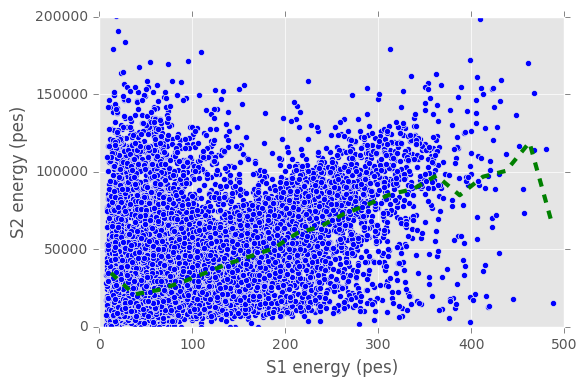

In [166]:
plt.scatter(maxs1, maxs2)
s1p, s2p, s2e = fit.profileX(maxs1, maxs2, 20, (0, 500))
plt.plot(s1p, s2p, "g--", linewidth=3)
plt.xlabel("S1 energy (pes)")
plt.ylabel("S2 energy (pes)")
plt.xlim(0, 500)
plt.ylim(0, 2e5)